In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import MLP
from ANFISpy import ANFIS

## Pre-Processing

Importing and converting data.

In [2]:
df = pd.read_csv('brazil_covid19_macro.csv')
cases = df['cases'].values
dates = df['date'].values
days = np.array([i for i in range(cases.shape[0])], dtype='float32')

Plotting.

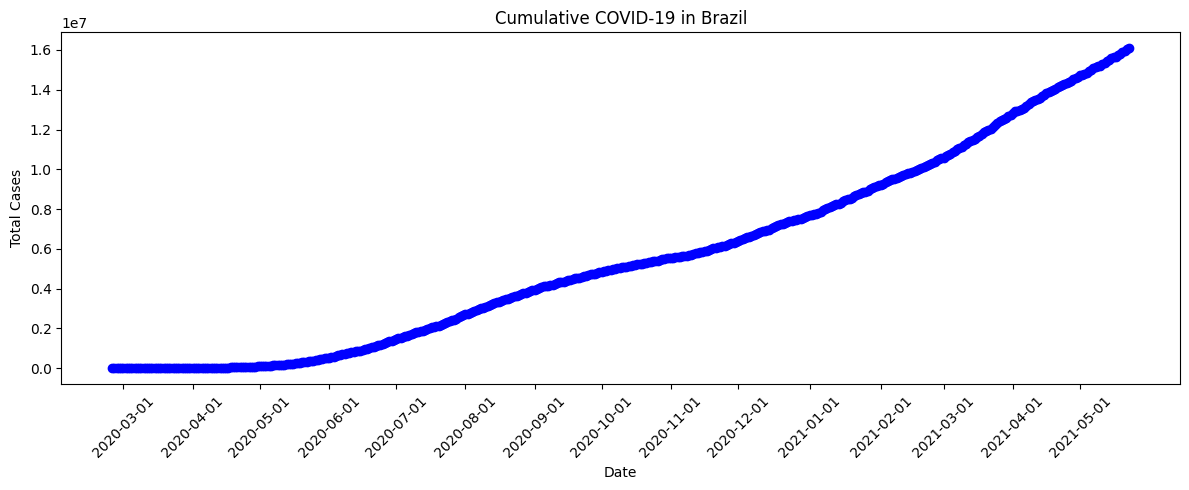

In [3]:
tick_indices = [i for i, d in enumerate(dates) if d.endswith('-01')]
tick_labels = [dates[i] for i in tick_indices]

plt.figure(figsize=(12, 5))
plt.scatter(days, cases, marker='o', c='blue')
plt.title('Cumulative COVID-19 in Brazil')
plt.ylabel('Total Cases')
plt.xlabel('Date')
plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.show()

Processing the data.

In [4]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size][1:]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test = (cases_test - norm_min) / (norm_max - norm_min)

def create_data(data):
    x = []
    y = []
    for i in range(len(data) - 1):
        x.append([data[i]])        
        y.append(data[i + 1])      
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

X_train, y_train = create_data(cases_train)
X_test, y_test = create_data(cases_test)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

## MLP

In [5]:
layers = [1]
for n in range(2):
    layers.append(44)
layers.append(1)
    
mlp = MLP(
    size_layers=layers,
    activation=nn.Identity(),
)

params_mlp = 0
for p in list(mlp.parameters()):
    params_mlp += p.flatten().shape[0]
    
print(f'Number of parameters: {params_mlp}')

Number of parameters: 2113


Training the model.

In [6]:
try:
    best_model_path = 'best_models/mlp.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    mlp.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=0.000143, weight_decay=0.000024)

    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/mlp.pth'

    for epoch in range(epochs):
        mlp.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = mlp(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 

        epoch_loss_train /= len(train_loader.dataset)

        if epoch_loss_train < best_train_loss:
                best_train_loss = epoch_loss_train
                torch.save({
                    'model_state_dict': mlp.state_dict(),
                }, best_model_path)

        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {epoch_loss_train:.7f}')

    checkpoint = torch.load(best_model_path, weights_only=True)
    mlp.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting.

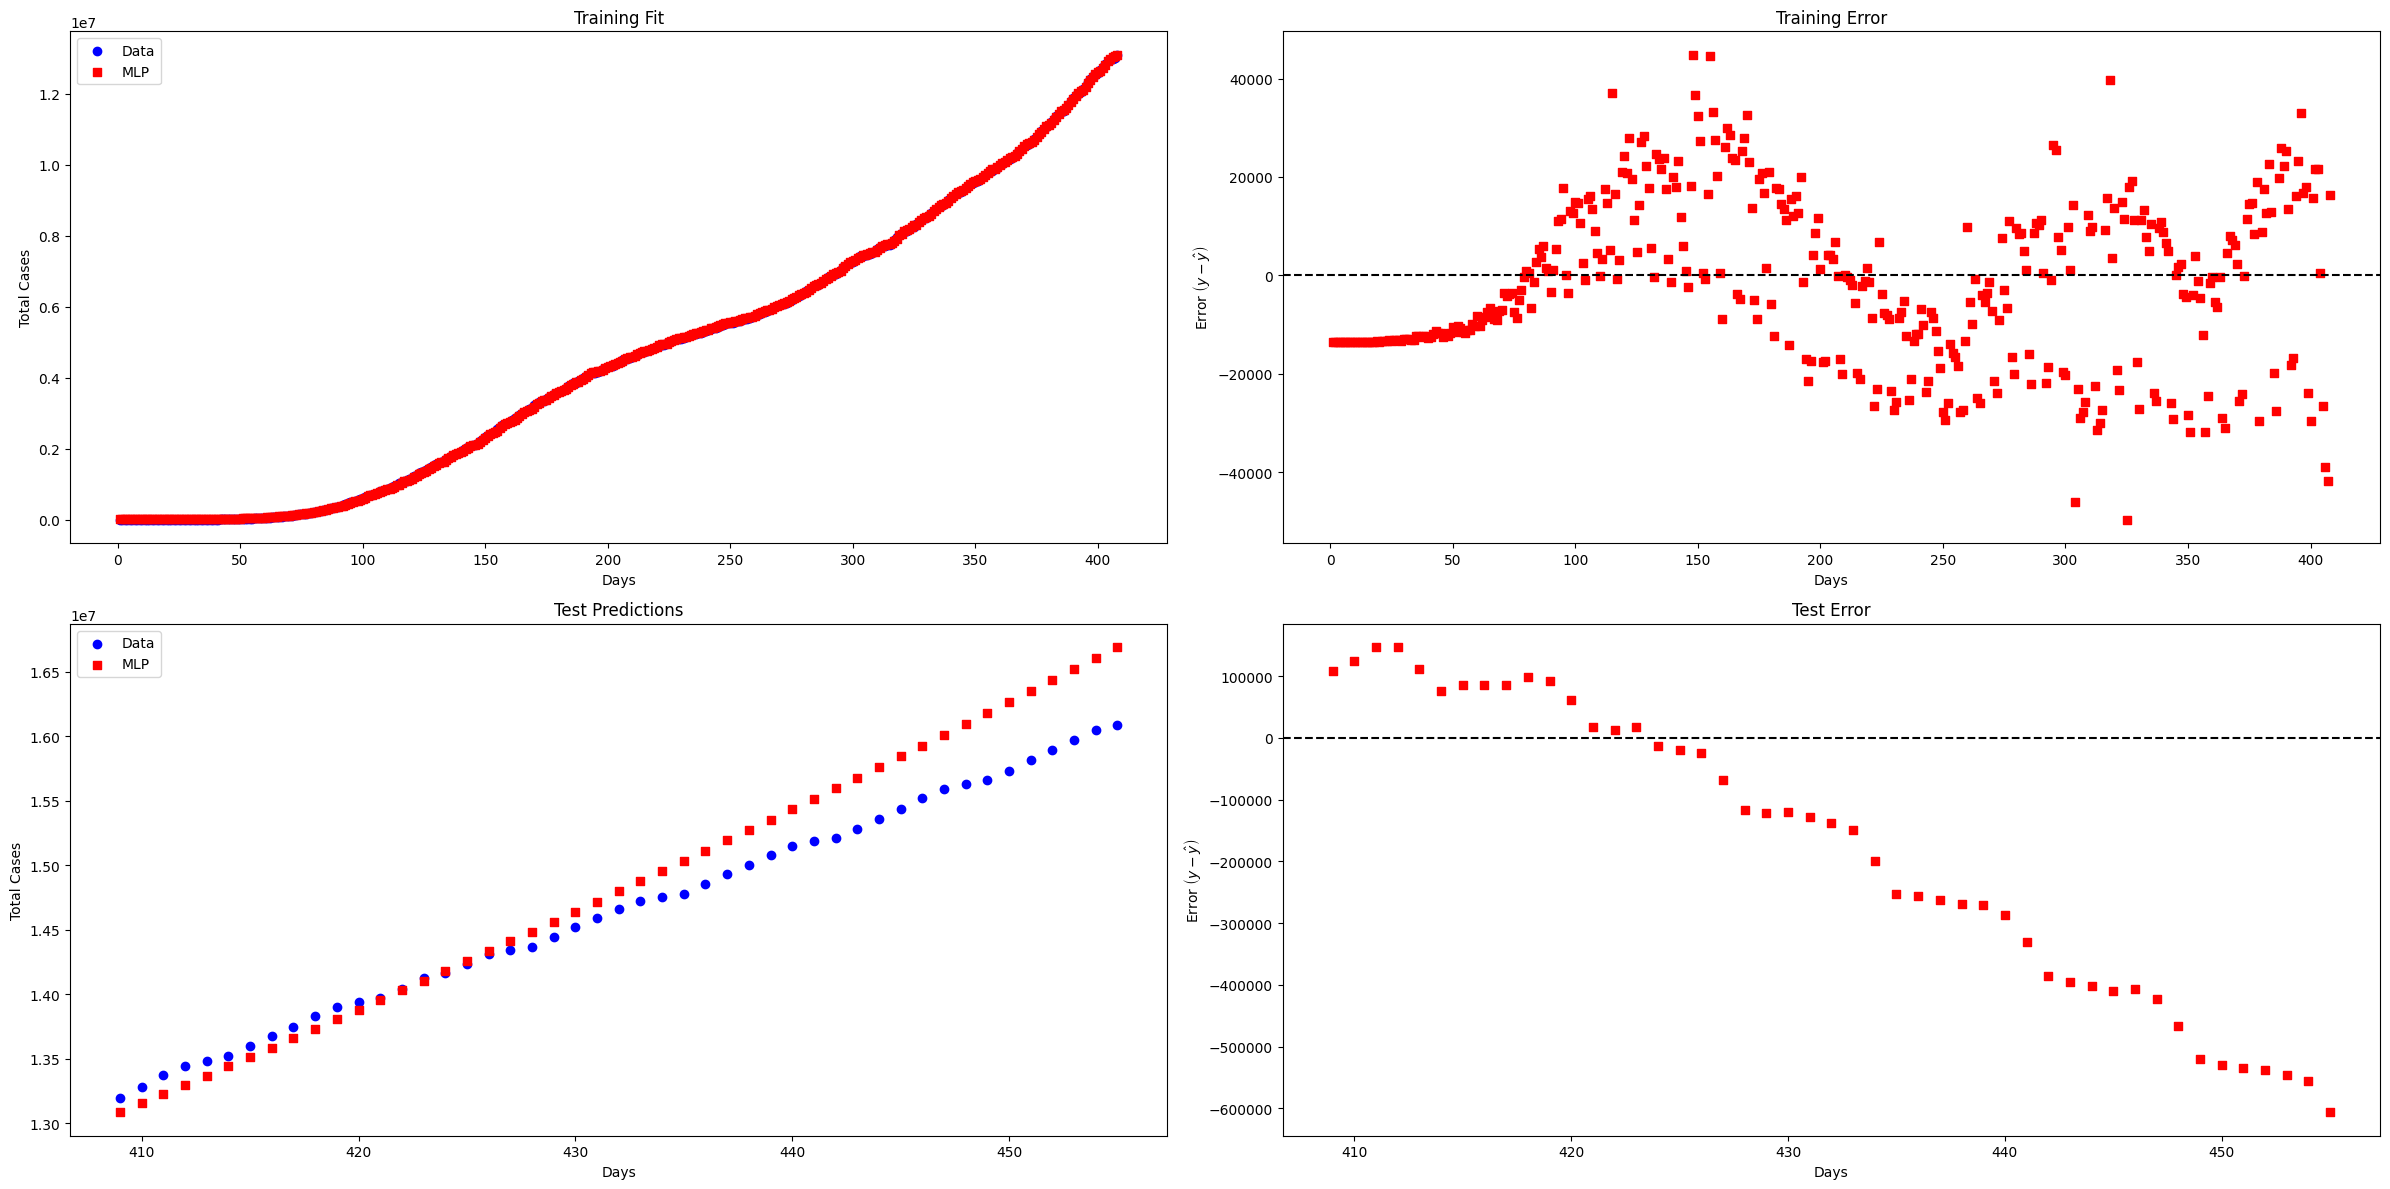

In [7]:
mlp.eval()
test_predictions_mlp = []

with torch.no_grad():
    train_predictions_mlp = mlp(X_train).squeeze()
    
    last_data = X_train[-1].unsqueeze(0)
        
    for _ in range(len(cases_test)):
        pred = mlp(last_data)
        test_predictions_mlp.append(pred.item())
        last_data = pred.detach()

train_predictions_mlp = train_predictions_mlp.numpy() * (norm_max - norm_min) + norm_min
test_predictions_mlp = np.array(test_predictions_mlp) * (norm_max - norm_min) + norm_min

y_train_denorm = y_train.numpy().flatten() * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test.flatten() * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(days_train, y_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(days_train, train_predictions_mlp, label='MLP', marker='s', c='red')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(days_train, y_train_denorm - train_predictions_mlp, color='red', marker='s')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_mlp, label='MLP', marker='s', c='red')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_mlp, color='red', marker='s')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## ANFIS

In [8]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size][1:]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test = (cases_test - norm_min) / (norm_max - norm_min)

def create_data(data):
    x = []
    y = []
    for i in range(len(data) - 1):
        x.append([data[i]])        
        y.append(data[i + 1])      
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)

X_train, y_train = create_data(cases_train)
X_test, y_test = create_data(cases_test)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

In [9]:
n_vars = 1
mf_names = [['L', 'ML', 'M', 'MH', 'H']]

variables = {
    'inputs': {
        'n_sets': [5],
        'uod': n_vars * [(0, 1.5)],
        'var_names': ['Cases'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'New Cases',
        'n_classes': 1,
    },
}

anfis = ANFIS(variables, 'gaussian', output_activation=nn.ReLU(), and_operator=torch.prod)

params_anfis = 0
for p in list(anfis.parameters()):
    params_anfis += p.flatten().shape[0]
    
print(f'Number of parameters: {params_anfis}')

Number of parameters: 20


Training.

In [10]:
try:
    best_model_path = 'best_models/anfis.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    anfis.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(anfis.parameters(), lr=0.006402, weight_decay=0.000224)
    
    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/anfis.pth'
    
    for epoch in range(epochs):
        anfis.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = anfis(X_batch).unsqueeze(-1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 
    
        epoch_loss_train /= len(train_loader.dataset)
    
        if epoch_loss_train < best_train_loss:
            best_train_loss = epoch_loss_train
            torch.save({
                'model_state_dict': anfis.state_dict(),
            }, best_model_path)
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {epoch_loss_train:.8f}')
    
    checkpoint = torch.load(best_model_path, weights_only=True)
    anfis.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting.

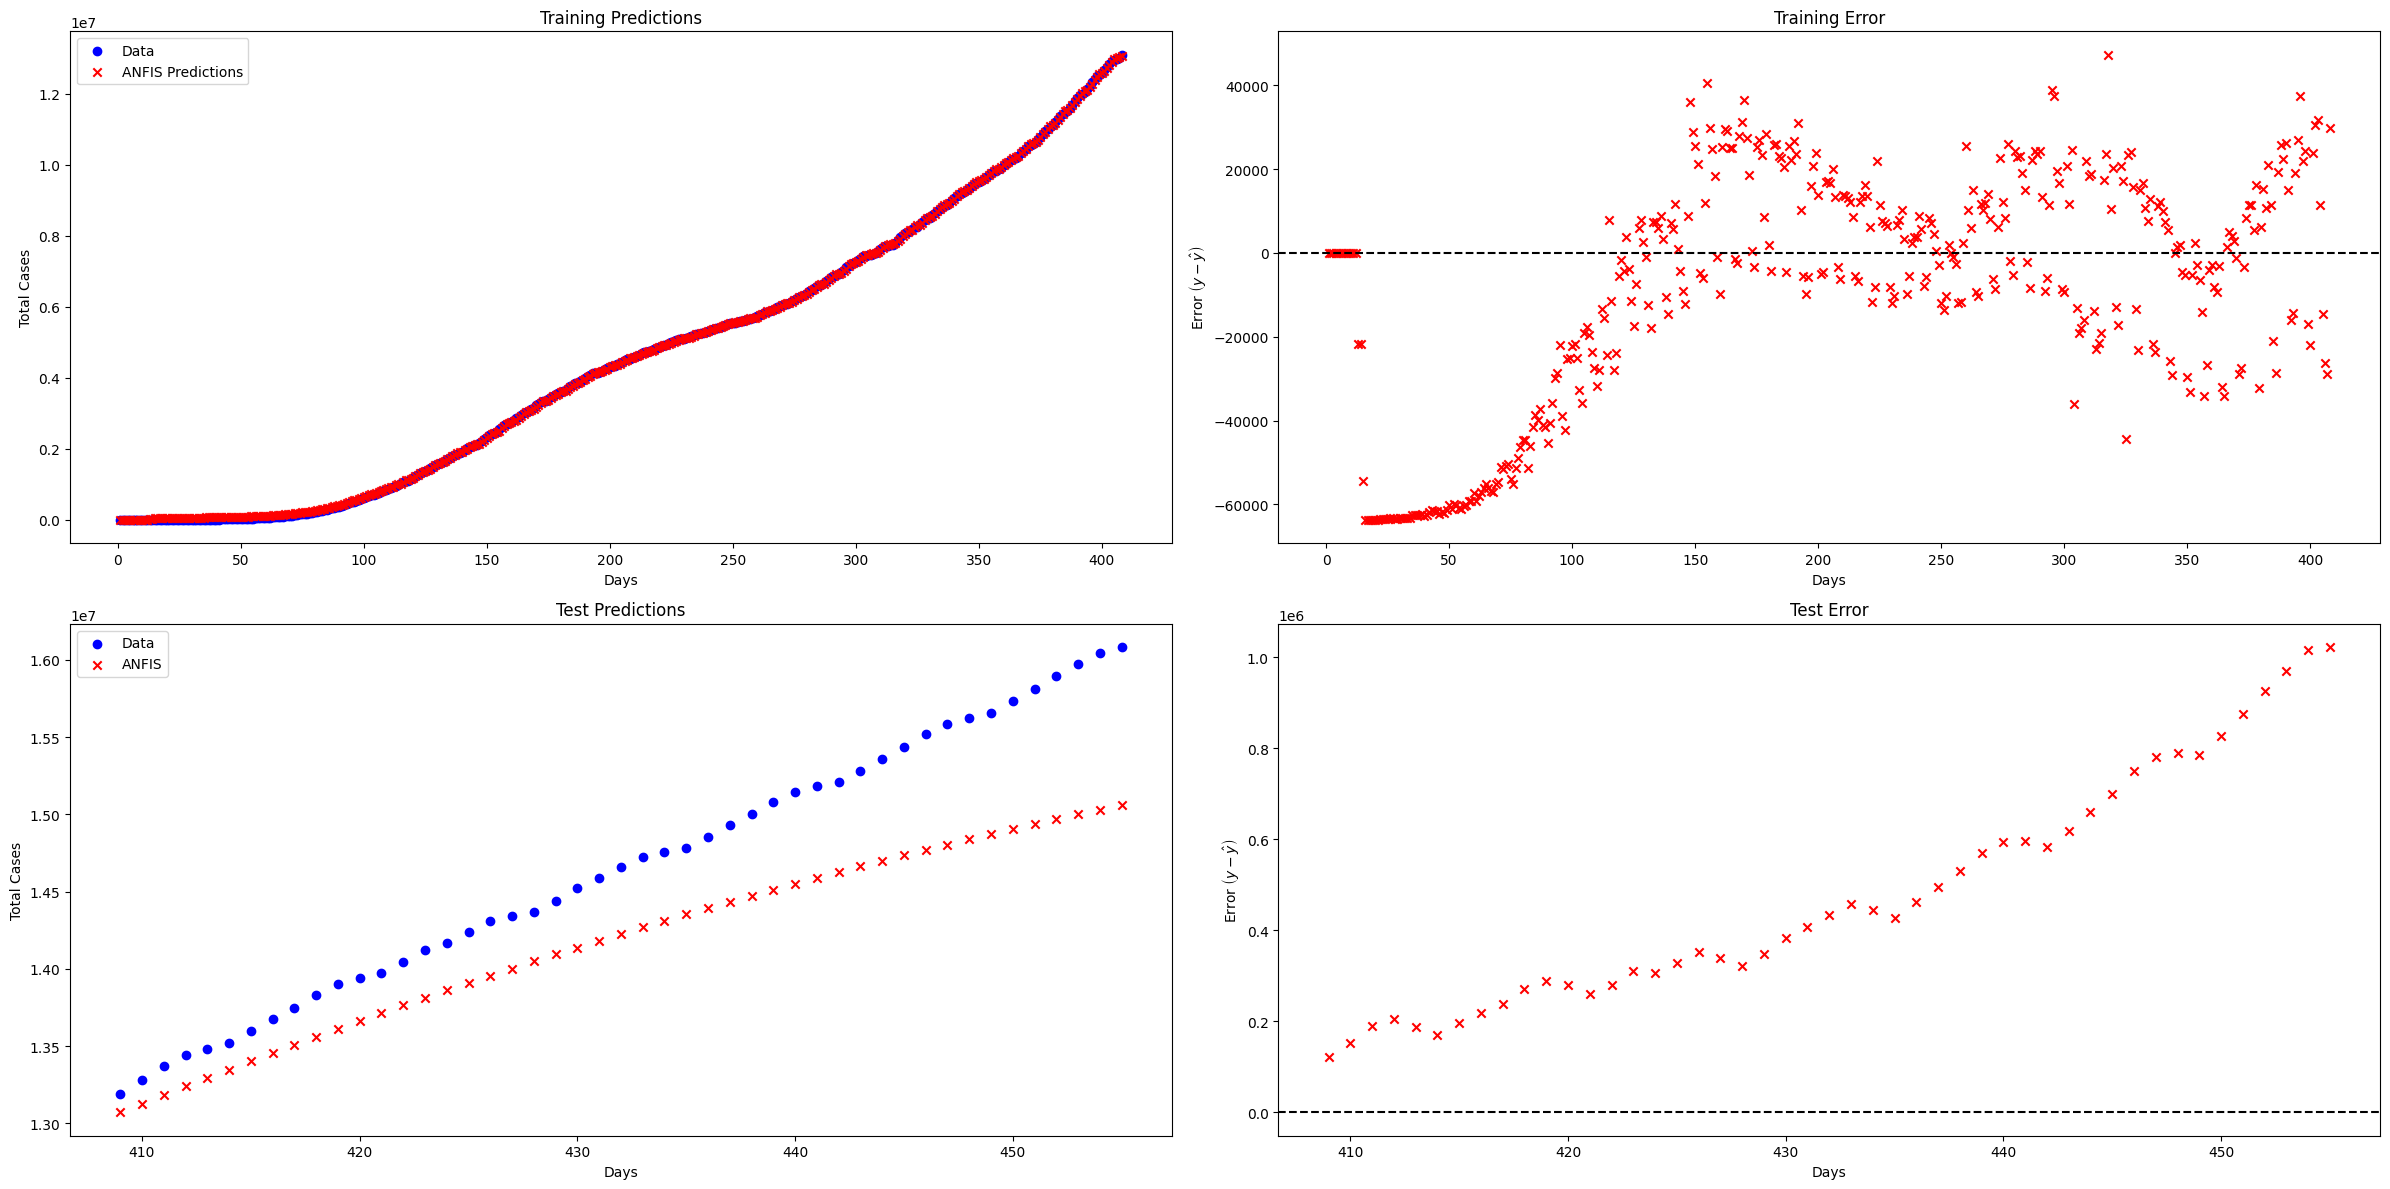

In [11]:
anfis.eval()
test_predictions_anfis = []

with torch.no_grad():
    train_predictions_anfis = anfis(X_train).squeeze()
    
    last_data = X_train[-1].unsqueeze(0)
    
    for _ in range(len(cases_test)):
        pred = anfis(last_data).unsqueeze(0)
        test_predictions_anfis.append(pred.item())
        last_data = pred.detach().view(1, 1)

train_predictions_anfis = train_predictions_anfis.numpy() * (norm_max - norm_min) + norm_min
test_predictions_anfis = np.array(test_predictions_anfis) * (norm_max - norm_min) + norm_min

y_train_denorm = y_train.numpy().flatten() * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test.flatten() * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(days_train, y_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(days_train, train_predictions_anfis, label='ANFIS Predictions', marker='x', c='red')
ax[0, 0].set_title("Training Predictions")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(days_train, y_train_denorm - train_predictions_anfis, color='red', marker='x')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_anfis, label='ANFIS', marker='x', c='red')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_anfis, color='red', marker='x')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## Final Analysis

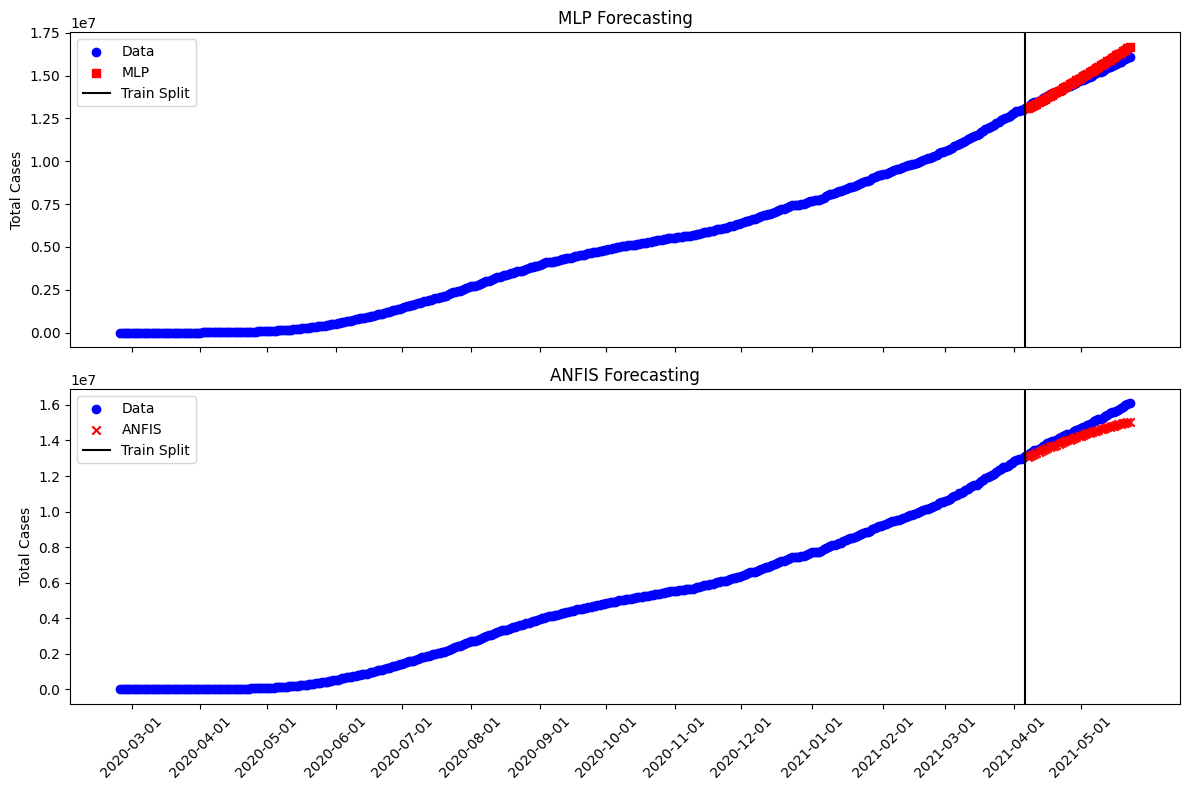

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].scatter(days, cases, label='Data', color='blue')
ax[0].scatter(days_test, test_predictions_mlp, label='MLP', color='red', marker='s')
ax[0].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[0].set_xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
ax[0].set_title('MLP Forecasting')
ax[0].set_ylabel('Total Cases')
ax[0].legend()

ax[1].scatter(days, cases, label='Data', color='blue')
ax[1].scatter(days_test, test_predictions_anfis, label='ANFIS', color='red', marker='x')
ax[1].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[1].set_xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
ax[1].set_ylabel('Total Cases')
ax[1].set_title('ANFIS Forecasting')
ax[1].legend()

plt.tight_layout()
plt.show()

In [13]:
rmse_mlp = np.sqrt(np.mean((cases_test_denorm - test_predictions_mlp)**2)).item()
rmse_anfis = np.sqrt(np.mean((cases_test_denorm - test_predictions_anfis)**2)).item()
mae_mlp = np.mean(np.abs(cases_test_denorm - test_predictions_mlp)).item()
mae_anfis = np.mean(np.abs(cases_test_denorm - test_predictions_anfis)).item()
mape_mlp = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_mlp) / cases_test_denorm)).item()
mape_anfis = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_anfis) / cases_test_denorm)).item()

ss_res_mlp = np.sum((cases_test_denorm - test_predictions_mlp) ** 2)
ss_tot = np.sum((cases_test_denorm - np.mean(cases_test_denorm)) ** 2)
r2_mlp = 1 - (ss_res_mlp / ss_tot)

ss_res_anfis = np.sum((cases_test_denorm - test_predictions_anfis) ** 2)
r2_anfis = 1 - (ss_res_anfis / ss_tot)

print(f'MLP   | RMSE: {int(rmse_mlp)} | MAE: {int(mae_mlp)} | MAPE: {mape_mlp:.2f}% | R²: {r2_mlp:.4f} | Parameters: {params_mlp}')
print(f'ANFIS | RMSE: {int(rmse_anfis)} | MAE: {int(mae_anfis)} | MAPE: {mape_anfis:.2f}% | R²: {r2_anfis:.4f} | Parameters: {params_anfis}')

MLP   | RMSE: 295698 | MAE: 234340 | MAPE: 1.54% | R²: 0.8733 | Parameters: 2113
ANFIS | RMSE: 540169 | MAE: 478082 | MAPE: 3.18% | R²: 0.5774 | Parameters: 20
